In [ ]:
import numpy
import yt
import h5py
from scipy.ndimage.interpolation import map_coordinates
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

infile = "/u/yali/"+folder+"/test/output/snapshot_""
cmap_name = 'CMRmap'

def customColorbar(fig, ax=None, cax=None, cmap='jet', norm=plt.Normalize, vmin=0, vmax=1, orientation='vertical'):
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=norm(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Ugh...
    sm._A = []
    if ax is None and cax is None:
        return fig.colorbar(sm, orientation=orientation)
    elif ax is None:
        return fig.colorbar(sm, cax=cax, orientation=orientation)
    elif cax is None:
        return fig.colorbar(sm, ax=ax, orientation=orientation)
    else:
        return fig.colorbar(sm, ax=ax, cax=cax, orientation=orientation)

def load_sim_step(step):

    #read data
    rfile = h5py.File(infile+".ts%04i"%step, "r")

    npdata = numpy.array(rfile["level_0"].get("data:datatype=0"))
    npdata = npdata.reshape(9,2097152)

    f_HI = npdata[2,:]
    f_HI = f_HI.reshape(128,128,128)

    redshift = rfile.attrs["redshift"][0]
    HII_frac = rfile.attrs["HII_frac_%"]

    #remove artifact in f_HI due to RADAMESH
    for ix in range(1,127):
        for iy in range(1,127):
            for iz in range(1,127):
                if f_HI[ix,iy,iz]<1e-3 and f_HI[ix+1,iy,iz]>0.99 and f_HI[ix,iy+1,iz]>0.99 and f_HI[ix,iy,iz+1]>0.99 and f_HI[ix-1,iy,iz]>0.99 and f_HI[ix,iy-1,iz]>0.99 and f_HI[ix,iy,iz-1]>0.99:
                    f_HI[ix,iy,iz] = 1.0
    
    
    rfile.close()

    return f_HI, redshift, HII_frac

def set_camera(scene):
    cam = scene.add_camera(ds, lens_type='perspective')  #camera
    cam.resolution = [1024,1024]
    cam.position = ds.arr([-100., -100., 100.], 'code_length')
    normal_vector = [1., 1., -1.]
    north_vector  = [0., 0., 1.]
    cam.switch_orientation(normal_vector=normal_vector,north_vector=north_vector)
    cam.set_width(2*ds.domain_width)

    return cam

def set_transfer_function(vol):

    def linramp(vals, minval, maxval):
        return (vals - vals.min())/(vals.max() - vals.min())
    
    vol.tfh.set_bounds([0.00001,1])
    vol.tfh.set_log(True)
    vol.tfh.set_field(r'f_HI')
    vol.tfh.build_transfer_function()
    vol.tfh.tf.grey_opacity = True
    vol.tfh.tf.map_to_colormap(-5,-0.1,colormap=cmap_name, scale=0.1)#scale_func=linramp)
    vol.tfh.tf.add_layers(10, colormap=cmap_name, mi=-5, ma=-0.1, col_bounds=[-5,-0.1], alpha=10*[100], w=0.0005)
    vol.tfh.plot("TF.png",profile_field='f_HI')
    

xHI = []
zs = []
for istep, step in enumerate(range(5,1111,5)):

    print('step ',step,'...')

    #load sim output
    f_HI, redshift, xHII = load_sim_step(step)
    zs.append(redshift)
    xHI.append( 1-0.01*xHII )

    #build yt dataset
    datadict = dict(f_HI = (f_HI,'dimensionless'))
    bbox = numpy.array([[-50, 50], [-50, 50], [-50, 50]])

    ds = yt.load_uniform_grid(datadict, f_HI.shape, length_unit=(1.0,"Mpc"), bbox=bbox, nprocs=16)


    ###################
    ## 3D rendering  ##
    ###################

    #create scene and get source
    sc = yt.create_scene(ds,'f_HI')
    vol = sc[0]

    #create camera and set properties
    cam = set_camera(sc)

    #create the transfer function
    tf = set_transfer_function(vol)

    # Draw the domain boundary
    #sc.annotate_axes(alpha=2)
    sc.annotate_domain(ds, color=[1, 1, 1, 0.2])

    #get rendered image
    sc.save('temp.png',sigma_clip=3)
    img = mpimg.imread('temp.png')
    
    # Set up plot
    fig = plt.figure(figsize=(10.5,11), facecolor='black')
    fig.patch.set_facecolor('k')
    gs = GridSpec(10,40)
    gs.update(hspace=0, wspace=0)
    ax_img = fig.add_subplot( gs[0:9,0:39] )
    ax_bar = fig.add_subplot( gs[0:9,  39] )
    ax_spc = fig.add_subplot( gs[9  ,0:38] )

    # Plot dumped image
    ax_img.imshow(img)
    ax_img.text(0.05*cam.resolution[0],0.05*cam.resolution[1],r"$z=$%4.2f"%redshift,color='w',fontsize=25)
    ax_img.set_axis_off()
    ax_img.set_xticks([])
    ax_img.set_yticks([])


    # Plot xHI
    ax_spc.plot(zs, xHI, 'C1-')
    ax_spc.tick_params(color='w', grid_color='w', labelcolor='w', labelsize=25)
    ax_spc.yaxis.set_ticks_position('left')
    ax_spc.xaxis.set_ticks_position('bottom')
    ax_spc.spines['left'  ].set_color('w')
    ax_spc.spines['right' ].set_visible(False)
    ax_spc.spines['top'   ].set_visible(False)
    ax_spc.spines['bottom'].set_color('w')
    ax_spc.set_xlabel(r'z', size=25, color='w')
    ax_spc.set_ylabel(r'$\langle f_{HI} \rangle$', size=25, color='w')
    ax_spc.set_xlim([12, 3.5])
    ax_spc.set_xticks([10, 8, 6, 4])
    ax_spc.set_ylim([0,1])

    # Custom colorbar
    cb = customColorbar(fig, ax=None, cax=ax_bar, cmap=cmap_name, norm=plt.Normalize, vmin=0, vmax=1, orientation='vertical')
    cb.set_ticks(numpy.linspace(0,1,6,endpoint=True)[::-1])
    cb.ax.tick_params(color='k', grid_color='k', labelcolor='w', labelsize=25)
    cb.set_ticklabels(["0","-1","-2","-3","-4","-5"])
    cb.set_label(r'$\log( f_{HI} )$', size=25, color='w')

    plt.tight_layout()
    fig.savefig('bubbles%i.png'%istep,dpi=300,bbox='tight',bbox_inches='tight',facecolor=fig.get_facecolor(),transparent=True)

In [17]:
import pynbody
import numpy as np
folder = "gDisk1"
fname = str(format(0, "03d"))
f = pynbody.load("/u/yali/"+folder+"/test/output/snapshot_"+fname+".hdf5")
#f.loadable_keys()

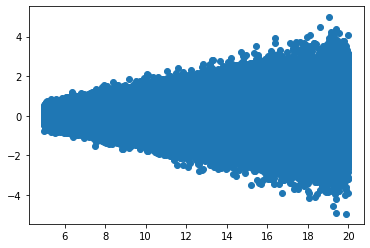

In [2]:
star = np.array([50, 50, 50])
@pynbody.derived_array
def rad(sim):
    return ((sim['pos'][:,0]-star[0])**2+(sim['pos'][:,1]-star[1])**2)**0.5
@pynbody.derived_array
def height(sim):
    return sim['pos'][:,2]-star[2]
import matplotlib.pyplot as plt
plt.scatter(f["rad"], f["height"])
#plt.scatter(f["pos"][:,0], f["pos"][:,2])
#plt.show()

In [31]:
#plt.scatter(f["rad"],f["phi"])
f["Acceleration"]

SimArray([[ 1.1136652 ,  0.48285043,  0.30484295],
          [ 0.75234085,  0.28715235,  0.34219566],
          [ 0.8043574 ,  0.12260523,  0.3170422 ],
          ...,
          [ 0.4081461 , -0.49842185, -0.3699098 ],
          [-0.07546467, -0.91175586, -0.4682892 ],
          [ 0.07161776, -0.88873583, -0.19381721]], dtype=float32)

In [22]:
import astropy
from astropy import constants as const
print(0.2*(const.h*const.c/const.k_B/30))
print(2*const.h*const.c**2)
print(const.M_sun)
UnitLength_in_cm = 1.496e13     
UnitMass_in_g = 1.989e33   
print(UnitMass_in_g/UnitLength_in_cm**2*0.06)

9.591845850026225e-05 K m
1.1910429723971884e-16 J m2 / s
  Name   = Solar mass
  Value  = 1.988409870698051e+30
  Uncertainty  = 4.468805426856864e+25
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018
533240.1555663588


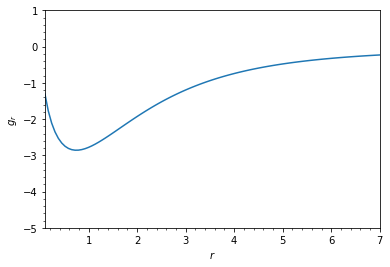

In [1]:
from galpy import potential 
from galpy.util import bovy_plot
import numpy
rp= potential.RazorThinExponentialDiskPotential(amp=10./(2.*numpy.pi),hr=1.)
rs= numpy.linspace(0.1,7.,101)
line_shell= bovy_plot.bovy_plot(rs,[rp.Rforce(r,0.) for r in rs],
                                yrange=[-5.,1.],
                                xlabel=r'$r$',
                                ylabel=r'$g_r$')